<font size="5"><b><font color="darkblue">Kaggle - Titanic: Machine Learning from Desaster: 81.34 Accuracy (Top 6 %)</b></font> 

<font size="3"><font color="#323231"><i>Goal of this project was to reach a scoring above 80% on the famous kaggle "Titanic" dataset. This was achieved
through careful feature engineering and using a 3 Layer Neural Network with Dropout and Batch Norm on this    augmented dataset.</font>

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1500)

<font size="3"><font color="#323231"><i>My first step was combining training and test dataset into one in order to have it easier to apply my transformations. To be able to seperate them later, I added a flag "Set" as a column to both data sources. I also saved the test sets "PassengerId" column, as this was needed later to build the submission file.

In [2]:
train = pd.read_csv("datasets/titanic/train.csv")
test = pd.read_csv("datasets/titanic/test.csv")
passenger_ids = test["PassengerId"]
test["Survived"] = 0
test["Set"] = "test"
train["Set"] = "train"
data = train.append(test, sort=True)

data.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Set,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,train,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,train,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,train,female,0,1,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,train,female,1,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,train,male,0,0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,train,male,0,0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,train,male,0,0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,train,male,3,0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,train,female,0,1,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,train,female,1,1,237736


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Set            1309 non-null object
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 143.2+ KB


<font size="4"><b><font color="darkblue"> Step 1: Exploratory Data Analysis</b></font>


<font size="3"><font color="#323231"><i>just from looking at the data, different conclusions can be drawn:
- There are Missing values in the following columns: "Age", "Cabin" and "Embarked". Especially the "Cabin" column was missing most of it's entries. 
- Some columns contain strings and must first be converted into a more useful format.
- Our labels are stored in the "Survived" column. Normally, there would be missing values for all the test set, but in our case, I decided to give those rows the label 0 as I needed that for a later transformation and after the whole process this column would be dropped from our test set anyways.
- Every "Cabin" entry starts with a letter (A, B, C, D, E, F, G) followed by a number.
- The "Name" column also stores some interesting information. From here it is possible to extract the passengers title e.g. "Mr", "Mrs", "Lady", "Master" ,... aswell as the last Name, that may be shared with other passengers.
- The payed fares a widely variable and range from less than 10 to more than 150.
    
Let's further explore those observations:

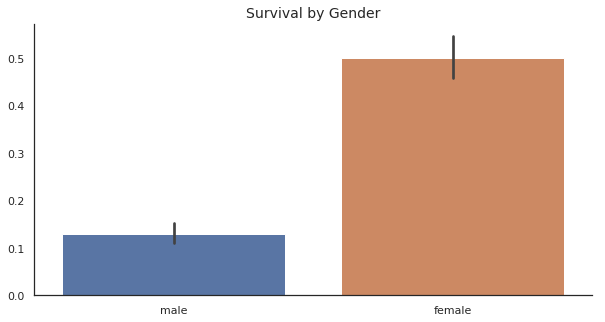

In [4]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white")
plt.title("Survival by Gender", {"fontsize": 14})
sns.barplot(x=data["Sex"], y=data["Survived"])
plt.ylabel("")
plt.xlabel("")
sns.despine()
plt.show()

<font size="3"><font color="#323231"><i>Males seem to have a significantly lower chance to survive.

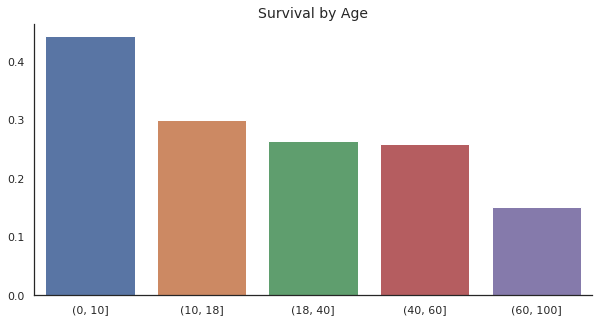

In [5]:
age_groups = data.groupby(pd.cut(data["Age"], [0, 10, 18, 40, 60, 100])).mean()
plt.title("Survival by Age", {"fontsize": 14})
sns.barplot(x=age_groups.index, y=age_groups["Survived"])
plt.ylabel("")
plt.xlabel("")
sns.despine()
plt.show()

<font size="3"><font color="#323231"><i>Children below 10 also seem to have better chances. The rate of survival decreases with increasing age.

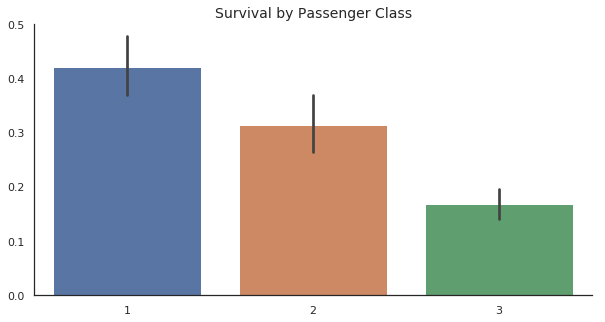

In [6]:
plt.title("Survival by Passenger Class", {"fontsize": 14})
sns.barplot(x=data["Pclass"], y=data["Survived"])
plt.ylabel("")
plt.xlabel("")
sns.despine()
plt.show()

<font size="3"><font color="#323231"><i>First class has better survival rates than the second and third.

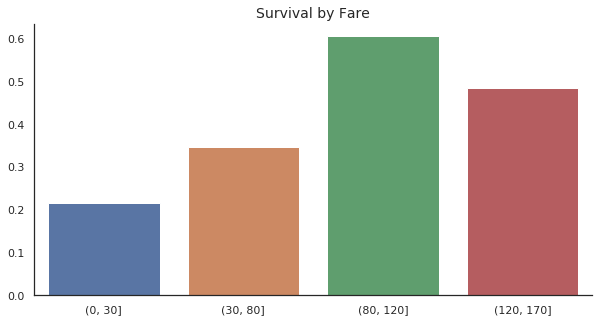

In [7]:
fare_groups = data.groupby(pd.cut(data["Fare"], [0,30,80,120, 170])).mean()
plt.title("Survival by Fare", {"fontsize": 14})
sns.barplot(x=fare_groups.index, y=fare_groups["Survived"])
plt.ylabel("")
plt.xlabel("")
sns.despine()
plt.show()

<font size="3"><font color="#323231"><i>Survival rates increse with higher fares, altough the passengers that payed the highest fares had a lower survival rate tha those with high to very high fares.

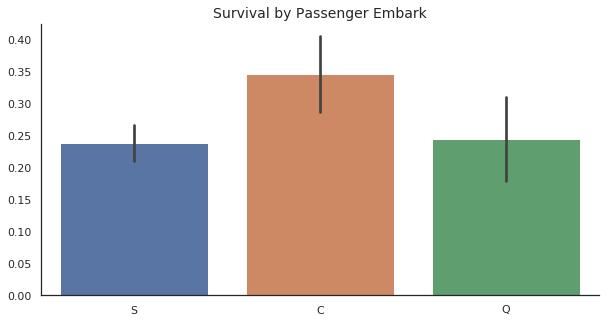

In [8]:
plt.title("Survival by Passenger Embark", {"fontsize": 14})
sns.barplot(x=data["Embarked"], y=data["Survived"])
plt.ylabel("")
plt.xlabel("")
sns.despine()
plt.show()

<font size="3"><font color="#323231"><i>Altough it looks like passengers that embarked in Cherbourg have higher survival rates, this is probably just a random occurance as it is unlikely that it really impacts ones ability to survive a ship crash by entering the ship at a different location ;-)

<font size="4"><b><font color="darkblue"> Step 2: Feature Engineering</b></font>


<font size="3"><font color="#323231"><i>We have found some major correlations just by exploring the data, altough some of our features created in the following steps were just ideas or were created after training some models to further enhance performance.

In [9]:
# I used multiple functions to transform the data set as this enhanced the readability and made the 
# process simpler. 

# this function will transform the "Sex" column from String to categorical, create an "Age_missing" column
# that indicates whether the ages was missing in the data set (Maybe it could not be recovered because the
# passenger died with his documents?) and whether the cabin number was missing (I decided to add this, maybe
# passengers that survived were responsible for entering their cabin numbers)

def cat_to_bool(df):
    df["Female"] = df["Sex"].str.get_dummies().iloc[:,0]
    df["Age_missing"] = df["Age"].isnull().astype("int64")
    df["Cabin_missing"] = df["Cabin"].isnull().astype("int64")

# the following functions are used to extract the title from the "Name" column of the dataset. Altough titles from 
# the test set were extracted, they were later dropped if they did not occur in the training set. 

def get_title(row):
    words = row.split(" ")
    for word in words:
        if word.endswith("."):
            return word[:-1]
    return np.nan

def extract_title(df):
    df["Title"] = df["Name"].apply(get_title)
    
# similar to the title extraction, these two functions extract the last names of the passengers. It was assumed
# that the last name was the first word in the "Name" column.

def get_last_name(row):
    words = row.split(" ")
    return words[0]
    
def extract_last_name(df):
    df["Last_name"] = df["Name"].apply(get_last_name)

# with the last names, it was possible to check wether a person of the same last name had survived the sinking.
# this proved to be a useful feature later on.
    
def relative_survived(df):
    last_name_survived = dict()
    train = df[df["Set"] == "train"]
    for last_name in train["Last_name"].unique():
        last_name_df = train[train["Last_name"] == last_name]
        survived = last_name_df["Survived"].sum()
        last_name_survived[last_name] = int(survived)
    df["Relative_survived"] = df["Last_name"].map(last_name_survived) - df["Survived"]
    df.loc[df["Relative_survived"] > 0, "Relative_survived"] = 1
    df.loc[df["Relative_survived"] == 0, "Relative_survived"] = 0

# next I added various other features:
#     - a column that counts how many passengers had the same cabin an thus indicates if two passengers shared the
#       same room
#     - a column that contains the letter of the cabin, which stands for the titanics floors
#     - a column that combines the "Parch" and "SibSp" columns to a column named "Family_size", 
#       as they contain very similar information
#     - a column that states whether the passenger traveled alone
#     - I normalized the "Fare" column by the distance that was traveled after the embarking. I assumed some 
#       distances for the whole trip by looking on a map and dividing the fares by different numbers. This did
#       increase the correlation to the survival rate by a tiny amount, so I decided to keep this instead of
#       the original "Fare" column
#     - I also constructed a column "Survivability_idx" that combined some features into a more useful index; I
#       decided to reduce the paid fare if the passenger was female in order to combat the already higher survival
#       chance, and add some penalty if the passenger traveled alone. 

def add_cols(df):
    train = df[df["Set"] == "train"]
    df["Cabin_counts"] = df["Cabin"].map(df["Cabin"].value_counts())
    df["Cabin"] = df["Cabin"].str[0]
    df["Family_size"] = df["Parch"] + df["SibSp"] + 1
    df["Alone"] = df["Family_size"] <= 1
    df["Fare_distance"] = df["Fare"]
    df.loc[df["Embarked"] == "S","Fare_distance"] = df.loc[df["Embarked"] == "S","Fare_distance"]/4.2
    df.loc[df["Embarked"] == "C","Fare_distance"] = df.loc[df["Embarked"] == "C","Fare_distance"]/3.5
    df.loc[df["Embarked"] == "Q","Fare_distance"] = df.loc[df["Embarked"] == "Q","Fare_distance"]/2.8
    df["Survivability_idx"] = (abs(df["Female"] - 0.7)) * df["Fare_distance"] + abs(df["Age"] - 40) * (abs(df["Alone"] - 0.6))

# to fill in the missing ages, I used following function which uses the titles to get the mean age for that 
# corresponding title and fill all missing values belonging to that same title with this mean age.

def guess_age(df):
    title_ages = dict()
    for title in df["Title"].unique():
        title_df = df[df["Title"] == title]
        title_ages[title] = title_df["Age"].mean()
    guessed_age = df["Title"].map(title_ages)
    df["Age"] = df["Age"].fillna(guessed_age)

# With this function, useless columns were dropped. I especially removed all non numeric columns and some columns
# that came from test set transformations or generally had high correlations with other columns such as "SibSp",
# "Parch" or "Fare"

def drop_cols(df):
    # dropping columns that are not useful or have already been converted
    df = df.drop(["PassengerId", "Name", "Sex", "Ticket", "Cabin", "Pclass", "Embarked", "Title",
                 "Title_Mlle", "Title_Dona", "Cabin_T", "Last_name",
                 "Title_Jonkheer","Title_Mme", "Parch", "SibSp", "Cabin_missing", "Fare",
                  "Cabin_F", "Title_Don"
                 ], axis=1, inplace=True)

# This function was used to create dummy columns for categoric features.  

def create_dummies(df):
    df[["Class_"+ str(s) for s in df["Pclass"].dropna().unique()]] = pd.get_dummies(df["Pclass"])
    df[["Title_"+ str(s) for s in df["Title"].dropna().unique()]] = pd.get_dummies(df["Title"])
    df[["Cabin_" + str(s) for s in df["Cabin"].dropna().unique()]] = pd.get_dummies(df["Cabin"])
    #df[["Embarked_" + str(s) for s in df["Embarked"].dropna().unique()]] = pd.get_dummies(df["Embarked"])

# The remaining missing values were filled with fitting values.

def replace_nan(df):
    df["Age"] = df["Age"].fillna(df[df["Set"] == "train"].loc[:,"Age"].mean())
    df["Cabin_counts"] = df["Cabin_counts"].fillna(-1)
    df["Relative_survived"] = df["Relative_survived"].fillna(0)

# combining all transformation functions:

def transform_df(df):
    cat_to_bool(df)
    extract_title(df)
    extract_last_name(df)
    relative_survived(df)
    guess_age(df)
    add_cols(df)
    create_dummies(df)
    replace_nan(df)
    drop_cols(df)
    
# Finally a function to ectract the numpy array used by the models from the Dataframe. This also took care
# of separating training and test set again.
def df_to_array(df):
    train = df[df["Set"] == "train"].drop("Set", axis=1)
    test = df[df["Set"] == "test"].drop("Set", axis=1)
    y = train["Survived"].values
    X = train.drop(["Survived"], axis=1).values
    X_test = test.drop(["Survived"], axis=1)
    return X, y, X_test
    
transform_df(data)

<font size="3"><font color="#323231"><i>After all this feature engineering, let us look at the correlations of the created features:
- The "Title" features are all over the place, I decided to largely ignore those correlations as those features are binary anyway
- The "Female" column has the highest correlation with "Survived" in the whole dataset
- The "Fare_distance" and "Relative_survived" aswell as "Alone" and "Survivability_idx" seem to be other useful features

In [10]:
train_transformed = data[data["Set"] == "train"]
train_transformed.corr()["Survived"].abs().sort_values(ascending=False)

Survived             1.000000
Title_Col            0.549199
Female               0.543351
Title_Capt           0.339040
Title_Lady           0.327093
Class_2              0.322308
Cabin_counts         0.311507
Class_3              0.285904
Fare_distance        0.260027
Relative_survived    0.227130
Alone                0.203367
Cabin_E              0.175095
Survivability_idx    0.170445
Cabin_D              0.150716
Cabin_A              0.145321
Cabin_G              0.114652
Class_1              0.093349
Age_missing          0.092197
Age                  0.087092
Title_Major          0.085221
Title_Sir            0.060095
Cabin_B              0.057935
Title_Countess       0.042470
Title_Miss           0.042470
Title_Dr             0.026456
Title_Mr             0.026456
Title_Master         0.026456
Cabin_C              0.022287
Family_size          0.016639
Title_Ms             0.011329
Title_Mrs            0.011329
Title_Rev            0.008185
Name: Survived, dtype: float64

<font size="3"><font color="#323231"><i>My next step was scaling the data. The features were on largely different scales and had to be normalized. I excluded all binary columns from this, as scaling those cold worsen our models performances. 

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
cat_cols = ["Female", "Age_missing", "Relative_survived", "Alone", "Class_3", "Class_2", "Class_1", "Title_Mr",
           "Title_Mrs", "Title_Ms", "Title_Major", "Title_Master", "Title_Miss", "Title_Rev", "Title_Dr",
           "Title_Lady", "Title_Sir", "Title_Col", "Title_Capt", "Title_Countess", "Cabin_C", "Cabin_E", "Cabin_G",
           "Cabin_D", "Cabin_A", "Cabin_B"]

data_cat = data[cat_cols]
data_cat[["Survived", "Set"]] = data[["Survived", "Set"]] 
data_num = data.drop(cat_cols, axis=1)
X_num, y, X_test_num = df_to_array(data_num)
X_cat, throwaway, X_test_cat = df_to_array(data_cat)

#print(data_num.drop(["Survived", "Set"], axis=1).columns)
#print(data_cat.drop(["Survived", "Set"], axis=1).columns)

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
X_scaled = np.c_[X_num_scaled, X_cat]

In [13]:
print(X_scaled.shape, y.shape)

(891, 31) (891,)


<font size="4"><b><font color="darkblue"> Step 3: Model Selection and Fine Tuning</b></font>


<font size="3"><font color="#323231"><i>I decided to try different models, but settled on three main ones as they proved to be the most promising:
- Logistic Regression
- Random Forests
- Deep Neural Network

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

<font size="3"><font color="#323231"><i>Model 1 - Logistic Regression:
- I used a mask to select the features used in my logistic regression model. In the following, all features
are selected, as I decided to stop using LR and focus on Neural Nets and Random Forests. With the right features,
the LR Model scored roughly 83% accuracy in cross validation.

In [15]:
lr_mask = [True, True, True, True, True, True, True, True, True, True,
           True, True, True, True, True, True, True, True, True, 
           True, True, True, True, True, True, True, True, True, 
           True, True, True]

lr_params = {
    "C": [0.1, 0.3, 1],
    "max_iter": [500]
}
lr_clf = LogisticRegression(solver="lbfgs", random_state=42)
lr_grid = GridSearchCV(lr_clf, lr_params, cv=10, scoring="recall")
lr_grid.fit(X_scaled[:, lr_mask], y)
print(lr_grid.best_params_)

{'C': 1, 'max_iter': 500}


In [16]:
print(lr_grid.cv_results_["mean_test_score"].max())

0.7630082335964689


<font size="3"><font color="#323231"><i>Model 2 - Decision Trees:
- I used scikit-learns SelectFromModel to get features that were useful in enhancing the decision trees impurity.
This method automatically filtered out some useless features. I manually tuned the cutoff threshold as a hyperparameter to maximize the CV score of my model.
- I used GridSearchCV in order to identify the best hyperparameters for my decision tree. In addition, I focused on maximizing the f1 score as I found that the accuracy was already pretty good on all hyperparameters.
- The model was used in my first few submissions (gradually adding more feature engineering and Fine Tuning) and scored roughly 80% accuracy on the kaggle test set, which put me in the top 15% on the Leaderboard.
    

In [17]:
sel_clf = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="0.3*mean")
sel_clf.fit(X_scaled, y)

all_cols = list(data_num.drop(["Survived", "Set"], axis=1).columns) + list(data_cat.drop(["Survived", "Set"], axis=1).columns)
sel_features = np.array(all_cols)[sel_clf.get_support()]
print(sel_features)
X_scaled = X_scaled[:, sel_clf.get_support()]  

['Age' 'Cabin_counts' 'Family_size' 'Fare_distance' 'Survivability_idx'
 'Female' 'Age_missing' 'Relative_survived' 'Alone' 'Class_3' 'Class_2'
 'Class_1' 'Title_Lady' 'Title_Col' 'Title_Capt']


In [18]:
rf_params = {
    "n_estimators": [200],
    "max_depth": [6],
    "min_samples_leaf": [2],
    "min_samples_split": [5],
    #"max_features": [14]
    "max_leaf_nodes": [37]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_clf, rf_params, cv= 10, scoring="f1_macro")
rf_grid.fit(X_scaled, y)
print(rf_grid.best_params_)

{'max_depth': 6, 'max_leaf_nodes': 37, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [19]:
print(rf_grid.cv_results_["mean_train_score"])

[0.87192245]


In [20]:
print(rf_grid.cv_results_["mean_test_score"].max())

0.8301679129949154


<font size="3"><font color="#323231"><i>The next step includes saving the predictions with the passenger Id's into a csv file that could be used to score the predictions using kaggles grader.

In [21]:
X_test_num = X_test_num.fillna(-1)
X_test_cat = X_test_cat.fillna(-1)

X_test_num_scaled = scaler.transform(X_test_num)
X_test_scaled = np.c_[X_test_num_scaled, X_test_cat]
X_test_scaled = X_test_scaled[:, sel_clf.get_support()]
predictions_test = rf_grid.best_estimator_.predict(X_test_scaled)

predicted = pd.DataFrame()
predicted["PassengerId"] = passenger_ids
predicted["Survived"] = predictions_test.astype("int32")
predicted.to_csv("preds.csv", header=True, index=False)


In [22]:
testing = pd.read_csv("preds.csv")
testing.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


<font size="3"><font color="#323231"><i>Model 3 - Deep Neural Network:
- I decided to give a Neural Network a try as my Random Forest was improving on the CV data but not on kaggles test set
- The network was created in tensorflow to allow for more customization; I decided to use dropout and batch normalization in the network. The dropoout rate was tuned like a Hyperparameter
- Weights were initialized using Xavier initialization
- Since the dataset is rather small, I implemented Cross Validation to get a more robust estimate of the networks performance
- For each fold, I stared with re-initializing the weights in order to prevent Overfitting. I also used slight l2 regularization and different dropout rates in the layers to reduce Overfitting
- After the training and scoring for each fold is finished, the network trains for 400 iterations on all of the data in order to make most of it.
- This Model scored better and worse on some folds, but could go up to 90% validation accuracy, averaging at around 84% during CV with low Overfitting. The predictions on the test data proved to be the best of all my models and scored 81.34% accuracy on kaggles grader, which puts it in the top 6% of models (at the time this notebook was written)
  
    

In [23]:
X_train_ = X_scaled.astype("float32")
y_train_ = y.astype("int32").reshape(-1, 1)
X_val_ = X_scaled.astype("float32")
y_val_ = y.astype("int32").reshape(-1, 1)
X_test_ = X_test_scaled.astype("float32")

In [24]:
tf.reset_default_graph()

In [25]:
n_inputs = X_train_.shape[1]
n_hidden_1 = 400
n_hidden_2 = 400
n_outputs = 1

learning_rate = 0.01

dropout_rate_0 = 0.2
dropout_rate_1 = 0.5
dropout_rate_2 = 0.15

training = tf.placeholder_with_default(False, shape=(), name="training")

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

with tf.name_scope("neural_network"):
    xavier_init = tf.contrib.layers.xavier_initializer()
    
    X_drop = tf.layers.dropout(X, dropout_rate_0, training=training)
    
    hidden_1 = tf.layers.dense(X_drop, n_hidden_1, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01), kernel_initializer=xavier_init, name="hidden_1")
    bn1 = tf.layers.batch_normalization(hidden_1, training=training, momentum=0.9)
    bn1_act = tf.nn.elu(bn1)
    hidden_1_drop = tf.layers.dropout(bn1_act, dropout_rate_1, training=training)
    
    hidden_2 = tf.layers.dense(hidden_1_drop, n_hidden_2, kernel_regularizer=tf.contrib.layers.l2_regularizer(0.01), kernel_initializer=xavier_init, name="hidden_2")
    bn2 = tf.layers.batch_normalization(hidden_2, training=training, momentum=0.9)
    bn2_act = tf.nn.elu(bn2)
    hidden_2_drop = tf.layers.dropout(bn2_act, dropout_rate_2, training=training)
    
    logits = tf.layers.dense(hidden_2_drop, n_outputs, kernel_initializer=xavier_init, name="outputs")

with tf.name_scope("loss"):
    #sigmoids = tf.nn.sigmoid(logits)
    #loss = y * -tf.log(sigmoids) + 3 * (1 - y) * -tf.log(1 - sigmoids) + tf.losses.get_regularization_loss()
    #loss = tf.reduce_mean(loss)
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss") + tf.losses.get_regularization_loss()
    
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    predicted = tf.round(tf.nn.sigmoid(logits))
    correct = tf.equal(predicted, y)
    
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    TP = tf.count_nonzero(predicted * y)
    TN = tf.count_nonzero((predicted - 1) * (y - 1))
    FP = tf.count_nonzero(predicted * (y - 1))
    FN = tf.count_nonzero((predicted - 1) * y)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    
    w = [v for v in tf.trainable_variables() if v.name == "hidden_1/kernel:0"][0]

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [26]:
def get_fold(fold, X=X_train_, y=y_train_, k_folds=10):
    m = X.shape[0]
    fold_size = np.ceil(m/k_folds)
    if fold != (k_folds-1):
        idx = slice(int(fold*fold_size), int((fold+1)*fold_size))
    elif fold == (k_folds-1):
        idx = slice(int(fold*fold_size), int(m-1))
    else:
        raise ValueError("Error at get_fold", fold)
        
    X_val = X[idx, :]
    y_val = y[idx, :]
    X_train = np.delete(X, idx, axis=0)
    y_train = np.delete(y, idx, axis=0)
    
    return X_train, y_train, X_val, y_val
    
n_epochs = 400
k_folds = 10

bn_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    train_accs = []
    val_accs = []
    train_f1 = []
    val_f1 = []
    
    init.run()
    
    for fold in range(0, k_folds+1):
        init.run()
        if fold < k_folds:
            X_train, y_train, X_val, y_val = get_fold(fold=fold, k_folds=10)
        if fold == k_folds:
            print("Training with all Data...")
            X_train = X_train_
            y_train = y_train_
        for epoch in range(n_epochs):
            sess.run([training_op, bn_updates], feed_dict={training: True, X: X_train, y: y_train})  
            if epoch % 100 == 0:
                #print(w.eval())
                if fold < k_folds:
                    print("Epoch: ", epoch, " Train_loss ", loss.eval(feed_dict={X: X_train, y: y_train}), "Val_loss", loss.eval(feed_dict={X: X_val, y: y_val}))
        
        acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
        acc_val = accuracy.eval(feed_dict={X: X_val, y: y_val})
        f1_train = f1.eval(feed_dict={X: X_train, y: y_train})
        f1_val = f1.eval(feed_dict={X: X_val, y: y_val})
        
        if fold < k_folds:
            train_accs.append(acc_train)
            val_accs.append(acc_val)
            train_f1.append(f1_train)
            val_f1.append(f1_val)
            
            print()
            print("Fold: ", fold+1)
            print("Training Accuracy: ", acc_train, " Validation Accuracy: ", acc_val)
            print("Training F1: ", f1_train, " Validation F1: ", f1_val)
            print()
            
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    mean_train_f1 = np.mean(train_f1)
    mean_val_f1 = np.mean(val_f1)
    
    predictions_test = predicted.eval(feed_dict={X: X_test_})
    save_path = saver.save(sess, "./my_model_final_3.ckpt")
    print("Mean Training Acc.: ", mean_train_acc, " Mean Validation Acc.: ", mean_val_acc, " Mean Training F1: ", mean_train_f1, " Mean Validation F1: ", mean_val_f1)

Epoch:  0  Train_loss  3.2982535 Val_loss 3.8188324
Epoch:  100  Train_loss  0.4352552 Val_loss 0.52110785
Epoch:  200  Train_loss  0.4336008 Val_loss 0.5119908
Epoch:  300  Train_loss  0.44887343 Val_loss 0.5273264

Fold:  1
Training Accuracy:  0.8451935  Validation Accuracy:  0.8333333
Training F1:  0.7891156462585035  Validation F1:  0.8

Epoch:  0  Train_loss  2.997153 Val_loss 3.2310205
Epoch:  100  Train_loss  0.44759002 Val_loss 0.45628658
Epoch:  200  Train_loss  0.45620748 Val_loss 0.45857835
Epoch:  300  Train_loss  0.44954303 Val_loss 0.497711

Fold:  2
Training Accuracy:  0.8426966  Validation Accuracy:  0.87777776
Training F1:  0.7913907284768212  Validation F1:  0.7441860465116279

Epoch:  0  Train_loss  3.1932993 Val_loss 3.2805176
Epoch:  100  Train_loss  0.43881238 Val_loss 0.5162769
Epoch:  200  Train_loss  0.43383673 Val_loss 0.54330224
Epoch:  300  Train_loss  0.43906426 Val_loss 0.53163

Fold:  3
Training Accuracy:  0.8489388  Validation Accuracy:  0.7777778
Traini

In [27]:
predicted = pd.DataFrame()
predicted["PassengerId"] = passenger_ids
predicted["Survived"] = predictions_test.astype("int32")
predicted.to_csv("preds_nn.csv", header=True, index=False)

In [28]:
testing = pd.read_csv("preds_nn.csv")
testing.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
